# Bootstrap One-Sample Hypothesis Test

## Objectives

- Introduce the bootstrap method for one-sample hypothesis testing.
- Demonstrate the process of generating bootstrap samples and computing test statistics.
- Use bootstrap techniques to test hypotheses about population means, variances, and skewness with simulated data.

## Background

This notebook explores the use of bootstrap methods for one-sample hypothesis testing, which involves resampling data with replacement to approximate the sampling distribution of a statistic. This non-parametric approach allows for the estimation of standard errors, construction of confidence intervals, and hypothesis testing without relying on the normality assumption of the data distribution.

## Datasets Used

The data used in this notebook is a synthetic dataset generated to simulate the heights of individuals, comprising 50 integer values ranging from 158 to 175. This dataset serves as the basis for various bootstrap hypothesis tests, including mean, variance, and skewness tests.

## Introduction

A one-sample test determines whether or not a sample statistic is statistically different from a population value. We will now use a bootstrap method with the same purpose.

A bootstrap hypothesis test starts with a test statistic `t(x)` (not necessarily an estimate of a parameter).

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 15)

import matplotlib.pyplot as plt
import seaborn as sns;
sns.set_style("whitegrid")  

from statsmodels.distributions.empirical_distribution import ECDF

## Generating data

Let's start generating ficticious data.

In [2]:
# Generating data
np.random.seed(1234)
data = np.random.randint(158, 175, 50)
sample_mean = np.mean(data)
sample_mean

167.54

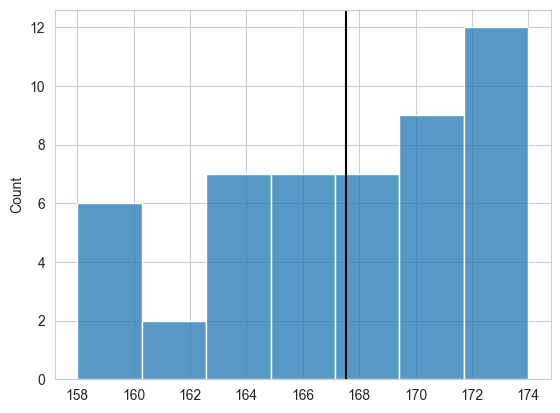

In [3]:
sns.histplot(x=data)
plt.axvline(x=sample_mean, color='black');

Our data does not follow a normal distribution.

## Calculating the sample distribution using bootstrap

Let us define `generate_samples_b` function to generate samples WITH REPLACEMENT using `sample_data`.

In [4]:
def generate_samples_b(sample_data, num_samples=10000):
    '''
    It generates num_samples samples using sample_data with the bootstrap method 
    and returns a DataFrame where each column is a sample.    
    '''
    sample_size = len(sample_data)
    col = ['S'+str(k) for k in range(num_samples)]
    samp = np.random.choice(sample_data, replace=True, size=sample_size*num_samples)
    df = pd.DataFrame(samp.reshape(sample_size, num_samples), columns=col)
    return(df)    

Let us generate 10,000 samples, and save them into a DataFrame.

In [5]:
dfSamples = generate_samples_b(data, num_samples=10000)
print(dfSamples.shape)
dfSamples.head()

(50, 10000)


,S0,S1,S2,S3,S4,S5,S6,...,S9993,S9994,S9995,S9996,S9997,S9998,S9999
0,170,164,163,174,158,173,169,...,170,170,174,169,173,160,173
1,174,163,172,169,170,164,173,...,169,164,168,160,163,160,163
2,166,173,170,170,169,160,158,...,160,169,164,160,170,164,160
3,174,161,167,163,170,174,169,...,170,164,169,169,167,174,169
4,174,164,174,165,167,169,167,...,161,173,163,160,169,160,172


We are going to use the mean as our statistic test.

`sample_distribution_mean` is a list with the mean of all samples.

In [6]:
sample_distribution_mean = dfSamples.mean() 

This is the histogram of `sample_distribution_mean`:

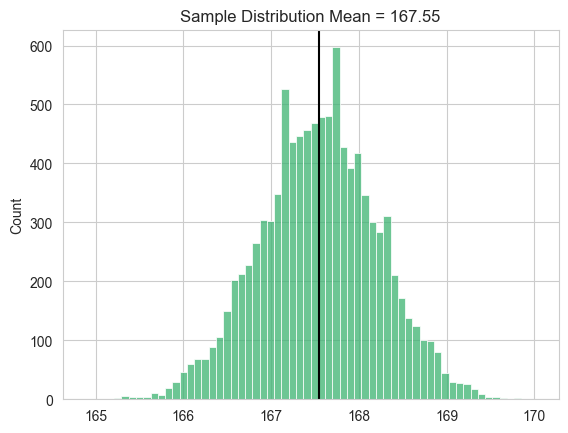

In [7]:
# Plotting a histogram of sample_distribution_mean
sns.histplot(x=sample_distribution_mean, color='mediumseagreen')
plt.axvline(x=sample_distribution_mean.mean(), color='black')
plt.title('Sample Distribution Mean = %.2f' %(np.mean(sample_distribution_mean)));

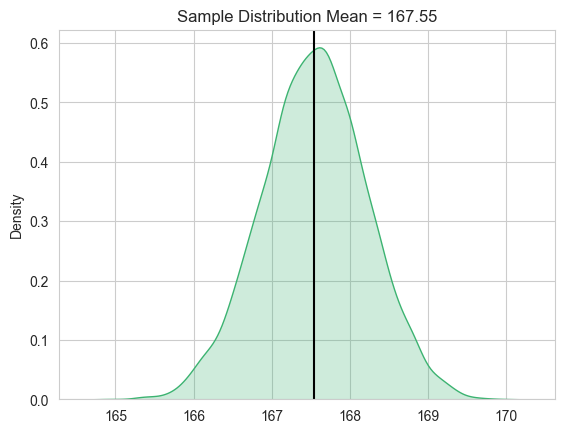

In [8]:
# kde plot of sample_distribution_mean
sns.kdeplot(x=sample_distribution_mean, color='mediumseagreen', fill=True)
plt.axvline(x=sample_distribution_mean.mean(), color='black')
plt.title('Sample Distribution Mean = %.2f' %(np.mean(sample_distribution_mean)));

## The hypothesis

Suppose we want to test the hypothesis:
- `Ho: mean   = 170`
- `Ha: mean != 170`

The first step is to construct the sample distribution under Ho; we need to build a sample distribution with a mean of `170`.

In [9]:
# sample distribution under Ho
sample_distribution_Ho = sample_distribution_mean - sample_distribution_mean.mean() + 170

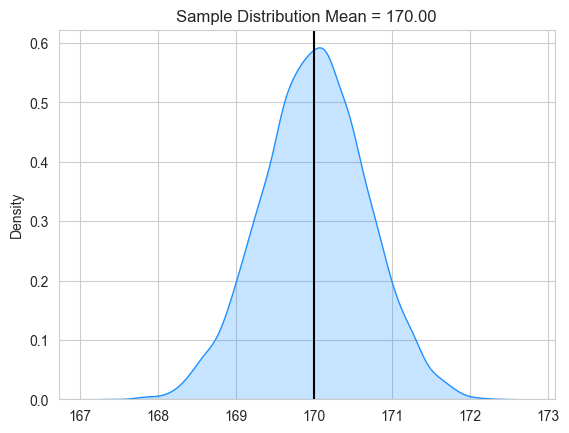

In [10]:
sns.kdeplot(x=sample_distribution_Ho, color='dodgerblue', fill=True)
plt.axvline(x=sample_distribution_Ho.mean(), color='black')
plt.title('Sample Distribution Mean = %.2f' %(np.mean(sample_distribution_Ho)));

## Critical Regions

We have three critical regions, according to the hypothesis we want to test:
- left
- right
- two-sided

To calculate the p-values, we will use two variables:
- `sample_distribution_Ho`: sample distribution under Ho
- `test_value`: hypothesized value

Let's define alpha = 0.05

In [11]:
# Defining alpha = 0.05
alpha = 0.05

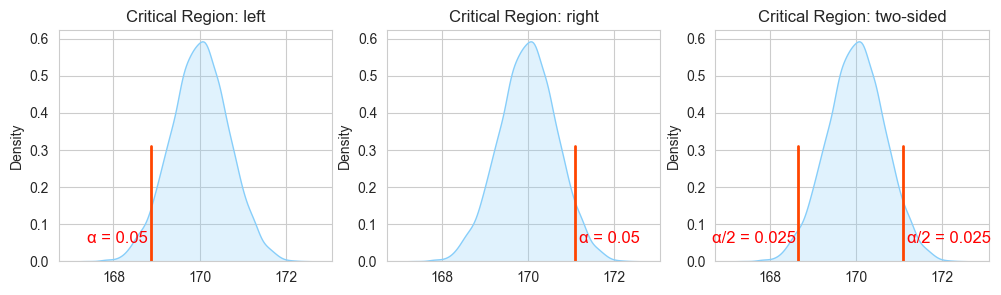

In [12]:
plt.figure(figsize=(12, 3))

plt.subplot(131)
ax = sns.kdeplot(x=sample_distribution_Ho, color='lightskyblue', fill=True)
cv1 = np.percentile(sample_distribution_Ho, alpha*100)              # left critical value   
plt.axvline(x = cv1, ymin=0, ymax=0.5, color='orangered', linewidth=2)
plt.text(cv1-1.5, 0.05, 'α = 0.05', color='red', size='12')
plt.title('Critical Region: left')

plt.subplot(132)
ax = sns.kdeplot(x=sample_distribution_Ho, color='lightskyblue', fill=True)
cv2 = np.percentile(sample_distribution_Ho, 100-alpha*100)          # right critical value 
plt.axvline(x = cv2, ymin=0, ymax=0.5, color='orangered', linewidth=2)
plt.text(cv2+0.1, 0.05, 'α = 0.05', color='red', size='12')
plt.title('Critical Region: right')

plt.subplot(133)
ax = sns.kdeplot(x=sample_distribution_Ho, color='lightskyblue', fill=True)
cv1 = np.percentile(sample_distribution_Ho, (alpha/2)*100)          # left critical value 
cv2 = np.percentile(sample_distribution_Ho, 100-alpha*100)          # right critical value      
plt.axvline(x = cv1, ymin=0, ymax=0.5, color='orangered', linewidth=2)
plt.axvline(x = cv2, ymin=0, ymax=0.5, color='orangered', linewidth=2)
plt.text(cv1-2, 0.05, 'α/2 = 0.025', color='red', size='12')
plt.text(cv2 + 0.1, 0.05, 'α/2 = 0.025', color='red', size='12')
plt.title('Critical Region: two-sided')

plt.show();

## Calculating the p-value

The p-value is the probability of getting a test statistic more extreme than the one we have calculated from our sample, given Ho is true.

We reject Ho if our p-value is small enough.

For calculating the p-value we will:
- Calculate the number of simulated test stats that are more extreme than our hypothesized `test_value`
- Calculate it using the empirical distribution function (ECDF)

Both options are equivalent. They get the same result.

Let us start defining the `test_value`:

In [13]:
test_value = 170

### p-value for alternative hypothesis: `smaller` (critical region: left)



- `Ho: measure = test_value`
- `Ha: measure <  test_value`

In our case, we will be testing: 

- `Ho: mean = 170`
- `Ha: mean < 170`

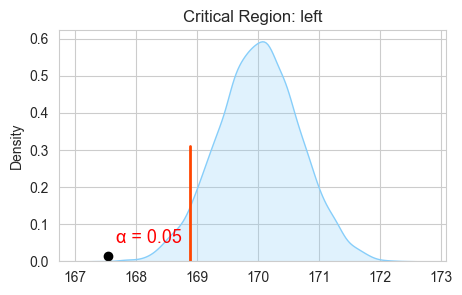

In [14]:
plt.figure(figsize=(5,3))
ax = sns.kdeplot(x=sample_distribution_Ho, color='lightskyblue', fill=True)
plt.plot(sample_mean, 0.015, 'o', color='black')
cv1 = np.percentile(sample_distribution_Ho, alpha*100)              # left critical value 
plt.axvline(x = cv1, ymin=0, ymax=0.5, color='orangered', linewidth=2)
plt.text(cv1-1.2, 0.05, 'α = 0.05', color='red', size='13')
plt.title('Critical Region: left');

Let us calculate the number of simulated test stats that are less than or equal to our `sample_mean`.

p-value is the area under the curve from -infinity to the `sample_mean`

In [15]:
lowtail = np.sum(np.array(sample_distribution_Ho)<=sample_mean)
pval_s = lowtail/(len(sample_distribution_Ho))
print('Smaller alternative hypothesis: p-value = %.4f' %pval_s)

Smaller alternative hypothesis: p-value = 0.0002


Let us calculate the p-value using the empirical distribution.

In [16]:
# Creating the empirical distribution
ecdf = ECDF(sample_distribution_Ho)
pval_s = ecdf(sample_mean)
print('Smaller alternative hypothesis: p-value = %.4f' %pval_s)

Smaller alternative hypothesis: p-value = 0.0002


As you can see, both values are the same.

### p-value for alternative hypothesis: `larger` (critical region: right)

- `Ho: measure = test_value`
- `Ha: measure > test_value`

In our case, we will be testing: 

- `Ho: mean = 170`
- `Ha: mean > 170`

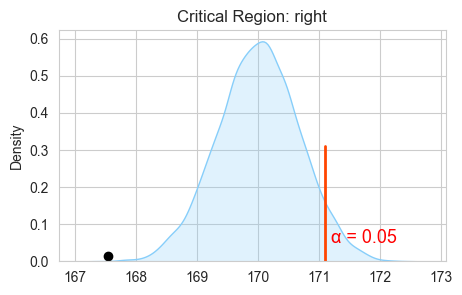

In [17]:
plt.figure(figsize=(5,3))
ax = sns.kdeplot(x=sample_distribution_Ho, color='lightskyblue', fill=True)
plt.plot(sample_mean, 0.015, 'o', color='black')
cv2 = np.percentile(sample_distribution_Ho, 100-alpha*100)      # right critical value
plt.axvline(x = cv2, ymin=0, ymax=0.5, color='orangered', linewidth=2)
plt.text(cv2+0.1, 0.05, 'α = 0.05', color='red', size='13')
plt.title('Critical Region: right');

p-value here is 1 - the area under the curve (pfd) from the `sample_mean` to infinity because it is a right critical region.

Let us calculate the number of simulated test stats that are greater than to our original `sample_mean`.

In [18]:
upptail = np.sum(np.array(sample_distribution_Ho)>sample_mean)
pval_l = upptail/(len(sample_distribution_Ho))
print('Larger alternative hypothesis: p-value = %.4f' %pval_l)

Larger alternative hypothesis: p-value = 0.9998


Let us calculate the p-value using the empirical distribution.

In [19]:
pval_l = 1 - ecdf(sample_mean)
print('Larger alternative hypothesis: p-value = %.4f' %pval_l)

Larger alternative hypothesis: p-value = 0.9998


Both ways produce the same p-value.

Notice that we can add both p-values (smaller and larger) and get 1. That is because they are complementaries.

In [20]:
print('Smaller alternative hypothesis: p-value = %.4f' %pval_s)
print('Larger alternative hypothesis: p-value  = %.4f' %pval_l)
print('Adding both values: %.1f' %(pval_s + pval_l))

Smaller alternative hypothesis: p-value = 0.0002
Larger alternative hypothesis: p-value  = 0.9998
Adding both values: 1.0


### p-value for alternative hypothesis: `two-sided` (critical region: two-sided)

- `Ho: measure  = test_value`
- `Ha: measure != test_value`

In our case, we will be testing: 

- `Ho: mean  = 170`
- `Ha: mean != 170`

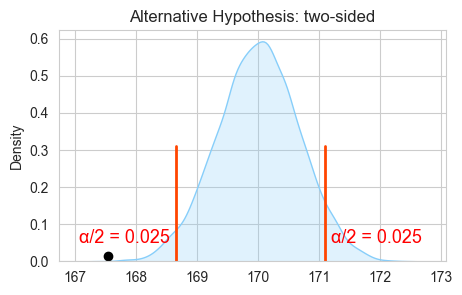

In [21]:
plt.figure(figsize=(5,3))
ax = sns.kdeplot(x=sample_distribution_Ho, color='lightskyblue', fill=True)
plt.plot(sample_mean, 0.015, 'o', color='black')
cv1 = np.percentile(sample_distribution_Ho, (alpha/2)*100)     # left critical value 
cv2 = np.percentile(sample_distribution_Ho, 100-alpha*100)     # right critical value
plt.axvline(x=cv1, ymin=0, ymax=0.5, color='orangered', linewidth=2)
plt.axvline(x=cv2, ymin=0, ymax=0.5, color='orangered', linewidth=2);
plt.text(cv1-1.6, 0.05, 'α/2 = 0.025', color='red', size='13')
plt.text(cv2+0.1, 0.05, 'α/2 = 0.025', color='red', size='13')
plt.title('Alternative Hypothesis: two-sided');

To calculate the p-value when the alternative hypothesis is two-sided, we need to determine whether the test_value is to the right or left in our graph, calculate the p-value in the usual way, and then duplicate it.

Let's calculate the minimum number of simulated test stats that are:
- less than or equal to test_vales, 
- greater than test_value

In [22]:
lowtail = np.sum(np.array(sample_distribution_Ho) <= sample_mean)
upptail = np.sum(np.array(sample_distribution_Ho)  > sample_mean)
pval_t = 2 * np.min([lowtail, upptail]) / len(sample_distribution_Ho)
print('Two-tailed test p-value = %.4f' %pval_t)

Two-tailed test p-value = 0.0004


Using ecdf:

In [23]:
p_val_t = 2 * np.min([ecdf(sample_mean), 1 - ecdf(sample_mean)])
print('Two-tailed test p-value = %.4f' %pval_t)

Two-tailed test p-value = 0.0004


We do not need to use both methods to get the p-value. We can use any of them.

Let us summarize the p-value calculation in one function.

In [24]:
def get_p_value(sample_distribution, obs_value, alternative='two-sided'):    
    '''
    It returns the p-value.
    sample_distribution: the sample distribution
    obs_value:           observed value     
    alternative:         'two-sided', 'smaller', or 'larger'    
    '''
    ecdf = ECDF(sample_distribution) 
    if alternative=='two-sided':
        p_val = 2*min(ecdf(obs_value), 1 - ecdf(obs_value))        
    elif alternative=='smaller':
        p_val = ecdf(obs_value)
    else:
        p_val = 1-ecdf(obs_value)
    return(p_val)

In [25]:
# Getting the p-value with an alternative hypothesis: smaller
pval = get_p_value(sample_distribution_Ho, sample_mean, alternative='smaller')
print('For alternative hypothesis smaller: p_value = %.4f' % pval)

For alternative hypothesis smaller: p_value = 0.0002


In [26]:
# Getting the p-value with an alternative hypothesis: larger
pval = get_p_value(sample_distribution_Ho, sample_mean, alternative='larger')
print('For alternative hypothesis larger: p_value = %.4f' % pval)

For alternative hypothesis larger: p_value = 0.9998


In [27]:
# Getting the p-value with an alternative hypothesis: two-sided (default)
pval = get_p_value(sample_distribution_Ho, sample_mean)
print('For alternative hypothesis two-sided: p_value = %.4f' % pval)

For alternative hypothesis two-sided: p_value = 0.0004


## One Sample Hypothesis Test with Bootstrapping

We have:
- data: a representative sample
- The hypothesis we want to test

We want to define a function for hypothesis testing.

### Defining a bootstrap function for one-sample hypothesis test

We will create a function for the hypothesis test. We could receive `data` as a parameter and use it to determine its mean and the sample distribution. The calculation of sample distribution is time-consuming, and we could use the same sample distribution to test several hypotheses. So, we decided to receive it as a parameter instead of calculating it in each call to the function.

In [28]:
def boot_1sample_HT(sample_value, sample_distribution, population_value, alpha=0.05, alternative='two-sided'):
    '''
    Bootstrap function for one-sample hypothesis test.
    sample_value:       observed value calculated from the sample
    sampl_distribution: sample distribution calculated from the sample
    pop_value:          population mean
    alpha:              significance level
    alternative:        'two-sided', 'smaller', and 'larger'
    '''
    sigHa = {'two-sided':'!=', 'smaller':'< ', 'larger':'> '}
    print('--- Bootstrap One-Sample Hypothesis Test ---')
    print('    Ho: measure = ', np.round(population_value, 2))    
    print('    Ha: measure', sigHa[alternative], np.round(population_value, 2))        
    sample_distribution_Ho = sample_distribution - np.mean(sample_distribution) + population_value
    # plotting the sample distribution
    sns.kdeplot(x=sample_distribution_Ho, color='skyblue', fill=True).set_title('Sampling Distribution')       
    # plotting the statistic value    
    plt.axvline(x=sample_value, ymin=0, ymax= 0.02, color='black', linewidth=6)
    # getting the p-value
    p_val = get_p_value(sample_distribution_Ho, sample_value, alternative)
    # plotting the graph with two critical regions
    if alternative=='two-sided':        
        cv1 = np.round(np.percentile(sample_distribution_Ho, (alpha/2)*100),2)      # left critical value     
        cv2 = np.round(np.percentile(sample_distribution_Ho, 100-(alpha/2)*100),2)  # right critical value
        plt.axvline(x = cv1, ymin=0, ymax=0.5, color='orangered', linewidth=2)  
        plt.axvline(x = cv2, ymin=0, ymax=0.5, color='orangered', linewidth=2)
    # plotting the graph with left critical region
    elif alternative=='smaller':        
        cv1 = np.round(np.percentile(sample_distribution_Ho, alpha*100),2)          # left critical value 
        plt.axvline(x = cv1, ymin=0, ymax=0.5, color='orangered', linewidth=2)
    # plotting the graph with right critical region
    else:                               
        cv2 = np.round(np.percentile(sample_distribution_Ho, 100-alpha*100),2)      # right critical value
        plt.axvline(x = cv2, ymin=0, ymax=0.5, color='orangered', linewidth=2)
    print('    Sample Mean = %.2f    p-value = %.4f' %(sample_value, p_val))

Let us use the function `boot_one_sample_HT` with `data` for the hypothesis.
- `Ho: mean = 170`
- `Ha: mean != 170`

--- Bootstrap One-Sample Hypothesis Test ---
    Ho: measure =  170
    Ha: measure != 170
    Sample Mean = 167.54    p-value = 0.0004


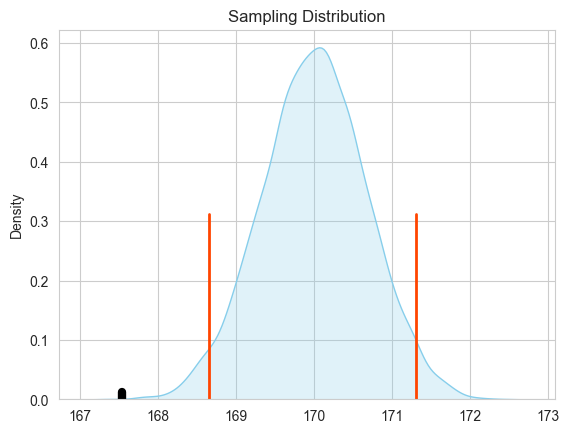

In [29]:
boot_1sample_HT(sample_mean, sample_distribution_mean, 170)

p-value < 0.05, we reject Ho. We conclude the mean is different from 170.

Let's analyse:
- `Ho: mean = 168`
- `Ha: mean != 168`

--- Bootstrap One-Sample Hypothesis Test ---
    Ho: measure =  168
    Ha: measure != 168
    Sample Mean = 167.54    p-value = 0.4880


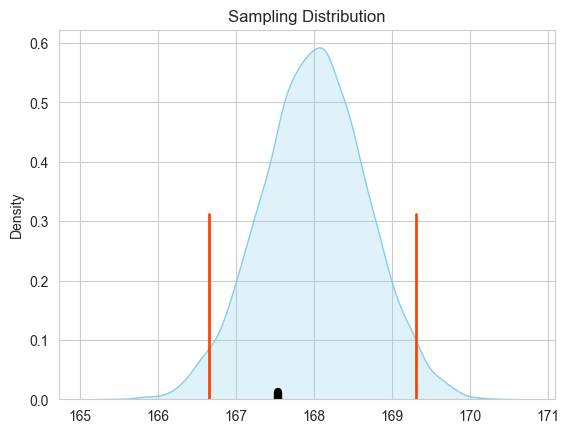

In [30]:
boot_1sample_HT(sample_mean, sample_distribution_mean, 168)

There are no reasons for rejecting Ho, and we cannot affirm the mean is different from 168.

Let's analyse:
- `Ho: mean = 166`
- `Ha: mean > 166`

--- Bootstrap One-Sample Hypothesis Test ---
    Ho: measure =  166
    Ha: measure >  166
    Sample Mean = 167.54    p-value = 0.0109


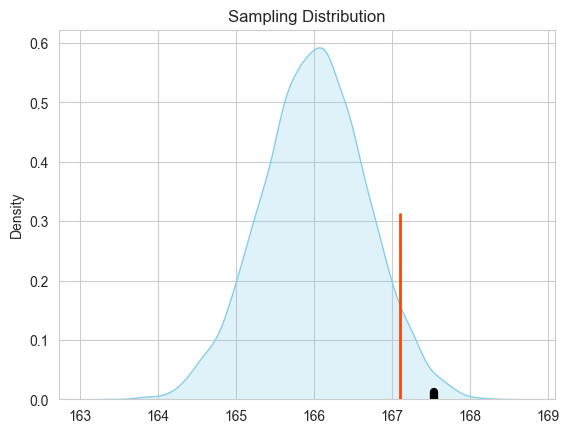

In [31]:
boot_1sample_HT(sample_mean, sample_distribution_mean, 166, alternative='larger')

p-value < 0.05, therefore we reject Ho and conclude the mean is greater than 166.

Let's compare this result with the traditional t-test.

### Testing the variance

Let's run the bootstrap hypothesis test for the variance.

The first step is calculate the sample distribution for the variance and the variance of our sample.

In [32]:
sample_distribution_var = dfSamples.var()
sample_var = np.var(data)

--- Bootstrap One-Sample Hypothesis Test ---
    Ho: measure =  20
    Ha: measure != 20
    Sample Mean = 22.29    p-value = 0.4922


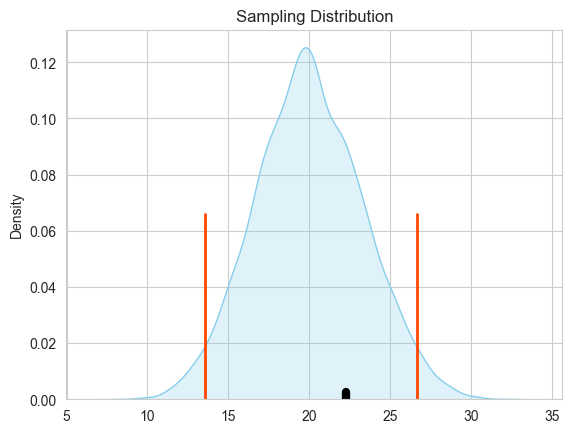

In [33]:
boot_1sample_HT(sample_var, sample_distribution_var, 20)

There are no reasons for rejecting Ho. The sample variance is not significantly different from 20.

What about variance = 30? Let's formulate the hypothesis:
- `Ho: var = 30`
- `Ha: var < 30`

--- Bootstrap One-Sample Hypothesis Test ---
    Ho: measure =  30
    Ha: measure <  30
    Sample Mean = 22.29    p-value = 0.0081


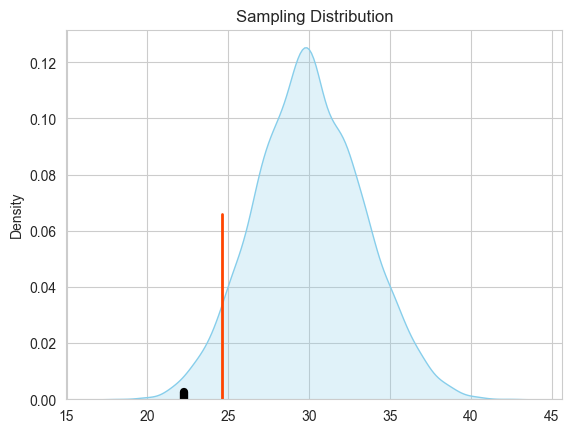

In [34]:
boot_1sample_HT(sample_var, sample_distribution_var, 30, alternative='smaller')

And indeed 22.29 < 30

### Testing the skew

Let's use the bootstrapping method to test the hypothesis involving the skewness of data:

- `Ho: skew = 0`
- `Ha: skew < 0`

We stat calculating the sample distribution for the skewness.

In [35]:
sample_distribution_skew = dfSamples.skew()

In [36]:
from scipy.stats import skew
sample_skew = skew(data)

--- Bootstrap One-Sample Hypothesis Test ---
    Ho: measure =  0
    Ha: measure <  0
    Sample Mean = -0.43    p-value = 0.0295


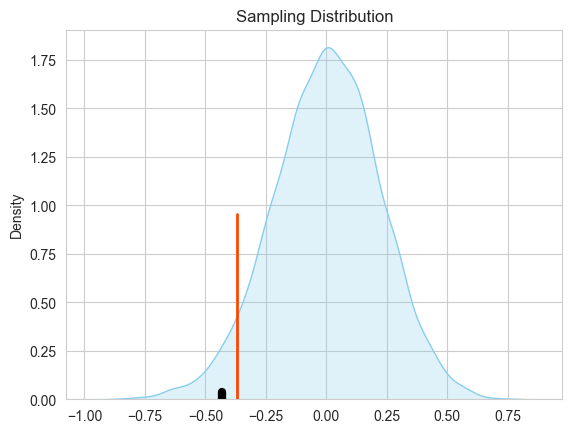

In [37]:
boot_1sample_HT(sample_skew, sample_distribution_skew, 0, alternative='smaller')

We conclude that the skewness is significantly less than 0.

## Conclusions

Key Takeaways:
- Bootstrap methods effectively estimate the sampling distribution of the mean, variance, and skewness, providing a flexible approach to hypothesis testing.
- The empirical results support the rejection or acceptance of null hypotheses based on computed p-values, demonstrating the effectiveness of Bootstrap in making statistical inferences.
- The flexibility of Bootstrap allows for hypothesis testing even when the sample size is relatively small and the underlying distribution of the data is unknown.
- Comparisons with traditional parametric tests show that Bootstrap can be a powerful alternative, especially in cases where the assumptions required for parametric tests are not met.

## References

- Davison, A.C., Hinkley, D.V. (1997) Bootstrap Methods and their Applications, chapter 4, Cambridge: Cambridge University Press.
- Bradley, E., Tibshirani, R.J. (1993) An Introduction to the Bootstrap. chapter 16, Boca Raton: Chapman & Hall/CRC.